# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data) + Player History



### Results that did the best from Decision Tree Classifier with player diff + one hot encoded categorial features:


# Summary of Results




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


from datetime import datetime
import pickle
import json
import os
import sys
import re
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
import util.model_util as mu
from util.model_util import RSTATE, N_JOBS, MAX_ITER, LABEL_COL
from sklearn.model_selection import train_test_split


%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "ohe-stats"

# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    mu.ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features_test-raw_diff-ohe-history-matchup-stats.csv'
    DESCRIPTION = f"{DESCRIPTION}-test"

else:
    # update this
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-raw_diff-ohe-history-matchup-stats.csv'

START_YEAR = 1985
END_YEAR = 2018



In [2]:
features = pd.read_csv(FEATURE_FILE)
features = features[features.tourney_year <= END_YEAR]
labels = features[LABEL_COL]

In [3]:
features1998 = features[features.tourney_year >= 1998]
labels1998 = features1998[LABEL_COL]

# Gradient Boosting - Baseline

If I didn't know anything about tennis, I would use seed diff to make my predictions.

From EDA, this should result in about 65% accuracy

In [4]:
def filter_baseline_features(data: pd.DataFrame):

    seed_filter = mu.BaseRankDiffFilter(data)
    new_data = seed_filter.get_data()
    
    return new_data

features_baseline = filter_baseline_features(features)

In [5]:
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(features_baseline, labels, random_state = RSTATE)

In [6]:

# train our model

gb_baseline = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-baseline', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_baseline,
                   y_train = y_train_baseline,
                   X_test = X_test_baseline,
                   y_test = y_test_baseline, 
                  data_filter = filter_baseline_features).fit()
y_predict_baseline = gb_baseline.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3648            1.99s
         2           1.3474            3.45s
         3           1.3331            2.78s
         4           1.3214            2.43s
         5           1.3118            2.20s
         6           1.3038            2.02s
         7           1.2973            1.93s
         8           1.2919            1.81s
         9           1.2875            1.70s
        10           1.2838            1.61s
        20           1.2689            1.16s
        30           1.2665            1.07s
        40           1.2660            0.95s


Model Score: 0.6531069827033953

ROC/AUC Score: 0.6531133501167702
              precision    recall  f1-score   support

        Loss       0.66      0.65      0.65     12522
         Win       0.65      0.66      0.65     12454

    accuracy                           0.65     24976
   macro avg       0.65      0.65      0.65     24976
weighted avg       0.65      0.65      0.65     24976

      Loss   Win
Loss  8149  4373
Win   4291  8163


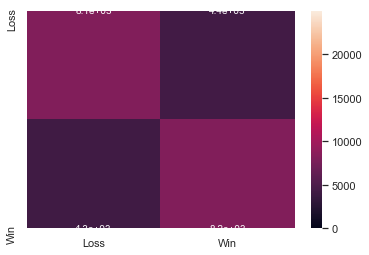

In [7]:
gb_baseline.analyze()

In [8]:
gb_baseline.save()

Saving report: ../reports/summary.csv


In [9]:
report = pd.DataFrame()
report = report.append({"accuracy": gb_baseline.accuracy, "description": gb_baseline.description}, ignore_index=True)

# Gradient Boosting - Raw Data(OHE) and Raw Stats

In [10]:
def filter_raw_plus_stats_features(data: pd.DataFrame):

    print(f'Before: shape {data.shape}')

    
    default = mu.DefaultColumnFilter(data)
    raw = mu.StatsRawFilter(data)
    
    new_data = pd.concat([default.get_data(), raw.get_data()], axis=1)
    
    print(f'After: shape {data.shape}')
    
    return new_data


In [11]:
features_raw = filter_raw_plus_stats_features(features)
# let's see what's left
[col for col in features_raw.columns if re.search("stats", col)]

Before: shape (99901, 5460)
After: shape (99901, 5460)


['p1_stats_1stin_avg',
 'p1_stats_1stwon_avg',
 'p1_stats_2ndwon_avg',
 'p1_stats_ace_avg',
 'p1_stats_bpfaced_avg',
 'p1_stats_bpsaved_avg',
 'p1_stats_df_avg',
 'p1_stats_svgms_avg',
 'p1_stats_svpt_avg',
 'p2_stats_1stin_avg',
 'p2_stats_1stwon_avg',
 'p2_stats_2ndwon_avg',
 'p2_stats_ace_avg',
 'p2_stats_bpfaced_avg',
 'p2_stats_bpsaved_avg',
 'p2_stats_df_avg',
 'p2_stats_svgms_avg',
 'p2_stats_svpt_avg']

In [12]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(features_raw, labels, random_state = RSTATE)

In [13]:

# train our model

gb = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_raw,
                   y_train = y_train_raw,
                   X_test = X_test_raw,
                   y_test = y_test_raw, 
                  data_filter = filter_raw_plus_stats_features).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3642           26.19m
         2           1.3461           25.77m
         3           1.3312           25.16m
         4           1.3183           24.85m
         5           1.3079           24.53m
         6           1.2990           24.22m
         7           1.2915           24.03m
         8           1.2853           23.58m
         9           1.2798           23.13m
        10           1.2750           22.66m
        20           1.2500           19.68m
        30           1.2390           17.17m
        40           1.2317           14.73m
        50           1.2270           12.26m
        60           1.2234            9.74m
        70           1.2203            7.29m
        80           1.2176            4.90m
        90           1.2151            2.48m
       100           1.2129            0.00s


Model Score: 0.6627562459961563

ROC/AUC Score: 0.6627623579064201
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66     12522
         Win       0.66      0.67      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8271  4251
Win   4172  8282


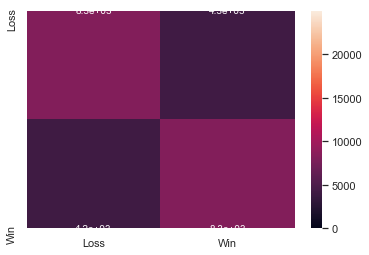

In [14]:
gb.analyze()

In [15]:
gb.save()

Saving report: ../reports/summary.csv


In [16]:
report = report.append({"accuracy": gb.accuracy, "description": gb.description}, ignore_index=True)

# Grandient Boosting - Raw Data(OHE) and Diff Stats

Diffed all time average player stats

In [17]:
import importlib
importlib.reload(mu)

def filter_stats_diff_features(data: pd.DataFrame):
    
    print(f'Before: shape {data.shape}')
    
    default = mu.DefaultColumnFilter(data)
    stats_diff = mu.StatsDiffFilter(data)
    new_data = pd.concat([default.get_data(), stats_diff.get_data()], axis=1)
    
    print(f'After: shape {new_data.shape}')
    
    return new_data

stats_diff = filter_stats_diff_features(features)
# let's see what's left
[col for col in stats_diff.columns if re.search("stats", col)]

Before: shape (99901, 5460)
After: shape (99901, 5262)


['p1_stats_1stin_avg_diff',
 'p1_stats_1stwon_avg_diff',
 'p1_stats_2ndwon_avg_diff',
 'p1_stats_ace_avg_diff',
 'p1_stats_bpfaced_avg_diff',
 'p1_stats_bpsaved_avg_diff',
 'p1_stats_df_avg_diff',
 'p1_stats_svgms_avg_diff',
 'p1_stats_svpt_avg_diff']

In [18]:
X_train_diff, X_test_diff, y_train_diff, y_test_diff = train_test_split(stats_diff, labels, random_state = RSTATE)

In [19]:

# train our model

gb_diff = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_diff,
                   y_train = y_train_diff,
                   X_test = X_test_diff,
                   y_test = y_test_diff, 
                  data_filter = filter_stats_diff_features).fit()
y_predict_gb_dfiff = gb_diff.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3637           24.90m
         2           1.3452           24.64m
         3           1.3299           24.31m
         4           1.3172           24.77m
         5           1.3066           24.99m
         6           1.2977           25.01m
         7           1.2902           24.96m
         8           1.2839           24.87m
         9           1.2785           24.72m
        10           1.2739           24.56m
        20           1.2506           21.47m
        30           1.2409           18.89m
        40           1.2348           16.05m
        50           1.2307           13.38m
        60           1.2268           10.74m
        70           1.2240            8.08m
        80           1.2212            5.38m
        90           1.2190            2.65m
       100           1.2163            0.00s


Model Score: 0.6619554772581678

ROC/AUC Score: 0.66197095809304
              precision    recall  f1-score   support

        Loss       0.67      0.66      0.66     12522
         Win       0.66      0.67      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8218  4304
Win   4139  8315


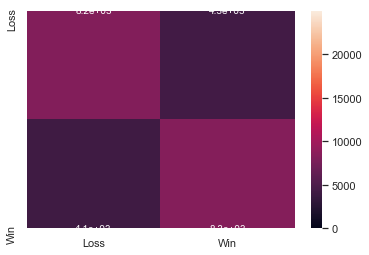

In [20]:
gb_diff.analyze()

In [21]:
gb_diff.save()

Saving report: ../reports/summary.csv


In [22]:
report = report.append({"accuracy": gb_diff.accuracy, "description": gb_diff.description}, ignore_index=True)

# Grandient Boosting - Raw Data(OHE) + stats5 diff

Average stats for each player diffed (ie, p1 - p2 stats)

In [23]:
import importlib
importlib.reload(mu)

def filter_stats5_diff_features(data: pd.DataFrame):
    
    print(f'Before: shape {data.shape}')
    
    default = mu.DefaultColumnFilter(data)

    stats_diff = mu.StatsDiffFilter(data)
    stats5_diff = mu.Stats5DiffFilter(data)

    new_data = pd.concat([default.get_data(), stats_diff.get_data(), stats5_diff.get_data()], axis=1)
    
    print(f'After: shape {new_data.shape}')
    
    return new_data

stats5_diff = filter_stats_diff_features(features)
# let's see what's left
[col for col in stats_diff.columns if re.search("stats", col)]

Before: shape (99901, 5460)
After: shape (99901, 5262)


['p1_stats_1stin_avg_diff',
 'p1_stats_1stwon_avg_diff',
 'p1_stats_2ndwon_avg_diff',
 'p1_stats_ace_avg_diff',
 'p1_stats_bpfaced_avg_diff',
 'p1_stats_bpsaved_avg_diff',
 'p1_stats_df_avg_diff',
 'p1_stats_svgms_avg_diff',
 'p1_stats_svpt_avg_diff']

In [24]:
X_train_diff5, X_test_diff5, y_train_diff5, y_test_diff5 = train_test_split(stats5_diff, labels, random_state = RSTATE)

In [25]:
gb_diff5 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff5', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_diff5,
                   y_train = y_train_diff5,
                   X_test = X_test_diff5,
                   y_test = y_test_diff5, 
                  data_filter = filter_stats5_diff_features).fit()
y_predict_gb_dfiff5 = gb_diff5.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3637           21.15m
         2           1.3452           20.79m
         3           1.3299           20.54m
         4           1.3172           20.36m
         5           1.3066           20.37m
         6           1.2977           20.53m
         7           1.2902           20.58m
         8           1.2839           20.59m
         9           1.2785           20.42m
        10           1.2739           20.08m
        20           1.2506           18.59m
        30           1.2409           16.21m
        40           1.2348           13.81m
        50           1.2307           11.44m
        60           1.2268            8.99m
        70           1.2240            6.67m
        80           1.2212            4.42m
        90           1.2190            2.21m
       100           1.2163            0.00s


Model Score: 0.6619554772581678

ROC/AUC Score: 0.66197095809304
              precision    recall  f1-score   support

        Loss       0.67      0.66      0.66     12522
         Win       0.66      0.67      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8218  4304
Win   4139  8315


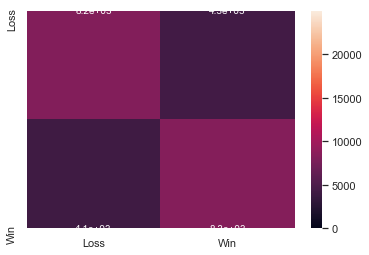

In [26]:
gb_diff5.analyze()

In [27]:
gb_diff5.save()

Saving report: ../reports/summary.csv


In [28]:
report = report.append({"accuracy": gb_diff5.accuracy, "description": gb_diff5.description}, ignore_index=True)

# Sample Weights

We saw from inital EDA, that upset rate is changing over the past couple of decades which means that earlier samples may not be as meaningful in our predictions as later samples. We will assign weights to our samples according to the year the tournament was in.

This first method assigns a different weight to each year with the last year in our samples 2018 having the highest weight.

We will compare results with the best so far:

```
Model Score: 0.6627562459961563

ROC/AUC Score: 0.6627623579064201
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66     12522
         Win       0.66      0.67      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976
```

In [29]:
importlib.reload(mu)
# assign sample weights
ywc = mu.IntervalBasedWeightCalculator(X_train_diff, "tourney_year", 1)
gb_diff_ywc = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff-weights_bin1', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_diff,
                   y_train = y_train_diff,
                   X_test = X_test_diff,
                   y_test = y_test_diff, 
                  data_filter = filter_stats_diff_features).fit(sample_weights = ywc.get_weights())
y_predict_gb_diff_ywc = gb_diff_ywc.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3622           26.47m
         2           1.3426           25.83m
         3           1.3262           25.49m
         4           1.3128           26.07m
         5           1.3015           25.95m
         6           1.2921           25.82m
         7           1.2840           25.61m
         8           1.2773           25.40m
         9           1.2715           25.21m
        10           1.2667           24.97m
        20           1.2418           22.09m
        30           1.2317           19.09m
        40           1.2250           15.76m
        50           1.2200           13.13m
        60           1.2157           10.55m
        70           1.2117            8.06m
        80           1.2082            5.55m


### This looks promising. Not drastic accuracy increase but there is some

Model Score: 0.6596732863549007

ROC/AUC Score: 0.6596958359229621
              precision    recall  f1-score   support

        Loss       0.66      0.65      0.66     12522
         Win       0.66      0.67      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8157  4365
Win   4135  8319


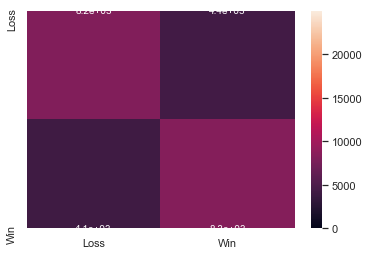

In [30]:
gb_diff_ywc.analyze()

In [31]:
gb_diff_ywc.save()

Saving report: ../reports/summary.csv


In [32]:
report = report.append({"accuracy": gb_diff_ywc.accuracy, "description": gb_diff_ywc.description}, ignore_index=True)

# Sample Weights - 10 bins

With this method, we will take years of tournament and construct equal sized bins. We wills start with 10 bins

We will compare results to the following:

```

```

In [33]:
# assign sample weights
ybwc10 = mu.BinBasedWeightCalculator(X_train_diff, "tourney_year", 10)
gb_diff_yb10 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff-weights_bin1', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                  data_filter = filter_stats_diff_features)
gb_diff_yb10.fit(X_train_diff, y_train_diff, sample_weights = ybwc10.get_weights())
y_predict_gb_diff_yb10 = gb_diff_yb10.predict(X_test_diff)

      Iter       Train Loss   Remaining Time 
         1           1.3622           29.01m
         2           1.3426           27.81m
         3           1.3263           27.09m
         4           1.3129           26.35m
         5           1.3017           25.83m
         6           1.2922           25.08m
         7           1.2841           25.10m
         8           1.2773           25.11m
         9           1.2716           25.08m
        10           1.2668           25.07m
        20           1.2420           22.12m
        30           1.2317           19.74m
        40           1.2252           17.29m
        50           1.2198           14.50m
        60           1.2155           11.30m
        70           1.2120            8.32m
        80           1.2084            5.63m


Model Score: 0.6612748238308777

ROC/AUC Score: 0.6612943329904776
              precision    recall  f1-score   support

        Loss       0.66      0.65      0.66     12522
         Win       0.66      0.67      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8191  4331
Win   4129  8325


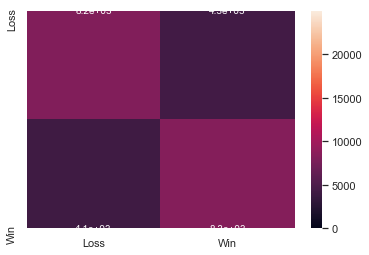

In [34]:
gb_diff_yb10.analyze(y_test_diff)

In [35]:
gb_diff_yb10.save()

Saving report: ../reports/summary.csv


In [36]:
report = report.append({"accuracy": gb_diff_yb10.accuracy, "description": gb_diff_yb10.description}, ignore_index=True)

# Sample Weights - Bin Every 5 Years

Since we saw in EDA that there might be a significant drop or increase in upset rates every 5 years. Our data covers 20 years, so let's try using 4 bins and see how this affects our model


We will compare results to the following:

```

```

In [37]:
# assign sample weights
ybwc4 = mu.IntervalBasedWeightCalculator(X_train_diff, "tourney_year", 5)
gb_diff_yb4 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff-weights_bin5yr', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                  data_filter = filter_stats_diff_features).fit(X_train_diff, y_train_diff, sample_weights = ybwc4.get_weights())
y_predict_gb_diff_yb4 = gb_diff_yb4.predict(X_test_diff)

      Iter       Train Loss   Remaining Time 
         1           1.3623           33.68m
         2           1.3427           33.59m
         3           1.3265           33.79m
         4           1.3131           33.08m
         5           1.3018           32.38m
         6           1.2924           32.68m
         7           1.2843           32.59m
         8           1.2777           32.18m
         9           1.2719           31.58m
        10           1.2670           31.10m
        20           1.2422           26.69m
        30           1.2321           23.58m
        40           1.2260           19.89m
        50           1.2204           16.26m
        60           1.2161           12.87m
        70           1.2121            9.53m
        80           1.2087            6.22m
        90           1.2062            3.12m
       100           1.2033            0.00s


Model Score: 0.6604740550928891

ROC/AUC Score: 0.6604839654361848
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66     12522
         Win       0.66      0.66      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8225  4297
Win   4183  8271


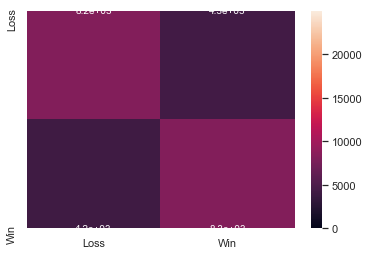

In [38]:
gb_diff_yb4.analyze(y_test_diff)

In [39]:
gb_diff_yb4.save()

Saving report: ../reports/summary.csv


In [40]:
report = report.append({"accuracy": gb_diff_yb4.accuracy, "description": gb_diff_yb4.description}, ignore_index=True)

#  History Diff Data Year Bin Every 5 Years

In [41]:
importlib.reload(mu)

def filter_history5_diff_features(data: pd.DataFrame):
    
    print(f'Before: shape {data.shape}')
    
    default = mu.DefaultColumnFilter(data)

    history_diff = mu.History5PercentageDiffFilter(data)

    new_data = pd.concat([default.get_data(), history_diff.get_data()], axis=1)
    
    print(f'After: shape {new_data.shape}')
    
    return new_data

history5_diff = filter_history5_diff_features(features)
# let's see what's left
[col for col in history5_diff.columns if re.search(r"history", col)]

Before: shape (99901, 5460)
After: shape (99901, 5256)


['p1_history5_games_won_percentage_diff',
 'p1_history5_sets_won_percentage_diff',
 'p1_history5_win_percentage_diff']

In [42]:
X_train_history5_diff, X_test_history5_diff, y_train_history5_diff, y_test_history5_diff = \
                train_test_split(history5_diff, labels, random_state = RSTATE)

In [43]:
gb_history5_diff = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-history5_diff-weight_bin5yr', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                  data_filter = filter_history5_diff_features)
gb_history5_diff.fit(X_train_history5_diff, y_train_history5_diff, sample_weights = ybwc4.get_weights())
y_predict_gb_history5_diff = gb_history5_diff.predict(X_test_history5_diff)

      Iter       Train Loss   Remaining Time 
         1           1.3642           33.16m
         2           1.3464           32.20m
         3           1.3317           31.68m
         4           1.3196           30.66m
         5           1.3097           29.81m
         6           1.3012           29.21m
         7           1.2942           28.71m
         8           1.2883           28.21m
         9           1.2833           27.77m
        10           1.2790           27.40m
        20           1.2581           23.07m
        30           1.2492           18.74m
        40           1.2443           15.64m
        50           1.2401           13.19m
        60           1.2366           11.07m
        70           1.2338            8.64m
        80           1.2313            5.88m
        90           1.2290            2.99m
       100           1.2269            0.00s


Model Score: 0.6556694426649584

ROC/AUC Score: 0.6556653641125263
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66     12522
         Win       0.65      0.65      0.65     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8229  4293
Win   4307  8147


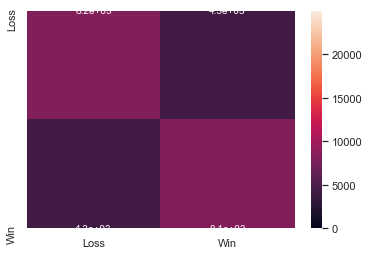

In [44]:
gb_history5_diff.analyze(y_test_history5_diff)

In [45]:
gb_history5_diff.save()

Saving report: ../reports/summary.csv


In [46]:
report = report.append({"accuracy": gb_history5_diff.accuracy, "description": gb_history5_diff.description}, ignore_index=True)

# Combine History Diff Data with Stats Diff and Bin Every 5 Years

In [47]:
importlib.reload(mu)

def filter_history_diff_stats5_diff_features(data: pd.DataFrame):
    
    print(f'Before: shape {data.shape}')
    
    default = mu.DefaultColumnFilter(data)

    stats_diff = mu.StatsDiffFilter(data)
    history_diff = mu.History5PercentageDiffFilter(data)

    new_data = pd.concat([default.get_data(), stats_diff.get_data(), history_diff.get_data()], axis=1)
    
    print(f'After: shape {new_data.shape}')
    
    return new_data

history5_stats5_diff = filter_history_diff_stats5_diff_features(features)
# let's see what's left
[col for col in history5_stats5_diff.columns if re.search(r"(stats|history)", col)]

Before: shape (99901, 5460)
After: shape (99901, 5265)


['p1_stats_1stin_avg_diff',
 'p1_stats_1stwon_avg_diff',
 'p1_stats_2ndwon_avg_diff',
 'p1_stats_ace_avg_diff',
 'p1_stats_bpfaced_avg_diff',
 'p1_stats_bpsaved_avg_diff',
 'p1_stats_df_avg_diff',
 'p1_stats_svgms_avg_diff',
 'p1_stats_svpt_avg_diff',
 'p1_history5_games_won_percentage_diff',
 'p1_history5_sets_won_percentage_diff',
 'p1_history5_win_percentage_diff']

In [48]:
X_train_history5_stats5_diff, X_test_history5_stats5_diff, y_train_history5_stats5_diff, y_test_history5_stats5_diff = \
                train_test_split(history5_stats5_diff, labels, random_state = RSTATE)

In [ ]:
gb_history5_stats5_diff = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-history5_diff-stats5_diff-weights_bin5yr', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                  data_filter = filter_history_diff_stats5_diff_features)
gb_history5_stats5_diff.fit(X_train_history5_stats5_diff, y_train_history5_stats5_diff, sample_weights = ybwc4.get_weights())
y_predict_gb_history_5_stats5 = gb_history5_stats5_diff.predict(X_test_history5_stats5_diff)

      Iter       Train Loss   Remaining Time 
         1           1.3623           46.16m
         2           1.3427           40.60m
         3           1.3265           38.70m
         4           1.3131           39.33m
         5           1.3018           39.23m
         6           1.2924           37.90m
         7           1.2843           37.06m
         8           1.2777           36.33m
         9           1.2719           35.69m
        10           1.2670           35.02m
        20           1.2422           28.98m
        30           1.2321           23.77m


In [ ]:
gb_history5_stats5_diff.analyze(y_test_history5_stats5_diff)

In [ ]:
gb_history5_stats5_diff.save()

In [ ]:
report = report.append({"accuracy": gb_history5_stats5_diff.accuracy, "description": gb_history5_stats5_diff.description}, ignore_index=True)

# Combine History Diff Data with Stats Diff and 5 Year Bins - 1998 Data

In [ ]:
importlib.reload(mu)

# def filter_history_diff_stats5_diff_features(data: pd.DataFrame):
    
#     print(f'Before: shape {data.shape}')
    
#     default = mu.DefaultColumnFilter(data)

#     stats_diff = mu.StatsDiffFilter(data)
#     history_diff = mu.History5PercentageDiffFilter(data)

#     new_data = pd.concat([default.get_data(), stats_diff.get_data(), history_diff.get_data()], axis=1)
    
#     print(f'After: shape {new_data.shape}')
    
#     return new_data

history5_stats5_diff1998 = filter_history_diff_stats5_diff_features(features1998)
# let's see what's left
[col for col in history5_stats5_diff1998.columns if re.search(r"(stats|history)", col)]

In [ ]:
X_train_history5_stats5_diff1998, X_test_history5_stats5_diff1998, y_train_history5_stats5_diff1998, y_test_history5_stats5_diff1998 = \
                train_test_split(history5_stats5_diff1998, labels1998, random_state = RSTATE)

In [ ]:
ybwc4_1998 = mu.IntervalBasedWeightCalculator(X_train_history5_stats5_diff1998, "tourney_year", 5)

gb_history5_stats5_diff1998 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-history5_diff-stats5_diff-weights_bin5yr', 
                 data_file = FEATURE_FILE,
                  start_year = 1998,
                  end_year = END_YEAR,
                  data_filter = filter_history_diff_stats5_diff_features)

gb_history5_stats5_diff1998.fit(X_train_history5_stats5_diff1998, y_train_history5_stats5_diff1998, sample_weights = ybwc4_1998.get_weights())

y_predict_gb_history_5_stats5_diff_1998 = gb_history5_stats5_diff1998.predict(X_test_history5_stats5_diff1998)

In [ ]:
importlib.reload(mu)
gb_history5_stats5_diff1998.analyze(y_test_history5_stats5_diff1998)

In [ ]:
gb_history5_stats5_diff1998.save()

In [ ]:
report = report.append({"accuracy": gb_history5_stats5_diff1998.accuracy, "description": gb_history5_stats5_diff1998.description}, ignore_index=True)

# History Diff - 5 year bins (1998)

In [ ]:
importlib.reload(mu)

def filter_history_diff_features(data: pd.DataFrame):
    
    print(f'Before: shape {data.shape}')
    
    default = mu.DefaultColumnFilter(data)

    history_diff = mu.History5PercentageDiffFilter(data)

    new_data = pd.concat([default.get_data(), history_diff.get_data()], axis=1)
    
    print(f'After: shape {new_data.shape}')
    
    return new_data

history5_diff1998 = filter_history_diff_features(features1998)
# let's see what's left
[col for col in history5_diff1998.columns if re.search(r"(stats|history)", col)]

In [ ]:
X_train_history5_diff1998, X_test_history5_diff1998, y_train_history5_diff1998, y_test_history5_diff1998 = \
                train_test_split(history5_diff1998, labels1998, random_state = RSTATE)

In [ ]:
ybwc4_1998 = mu.IntervalBasedWeightCalculator(X_train_history5_stats5_diff1998, "tourney_year", 5)

gb_history5_diff1998 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-history5_diff-bin5', 
                 data_file = FEATURE_FILE,
                  start_year = 1998,
                  end_year = END_YEAR,
                  data_filter = filter_history_diff_features)

gb_history5_diff1998.fit(X_train_history5_diff1998, y_train_history5_diff1998, sample_weights = ybwc4_1998.get_weights())

y_predict_gb_history_5_stats5_diff_1998 = gb_history5_diff1998.predict(X_test_history5_diff1998)

In [ ]:
importlib.reload(mu)
gb_history5_diff1998.analyze(y_test_history5_diff1998)

In [ ]:
gb_history5_diff1998.save()

In [ ]:
report = report.append({"accuracy": gb_history5_diff1998.accuracy, "description": gb_history5_diff1998.description}, ignore_index=True)

# History Diff - no Bin (1998)

In [ ]:
importlib.reload(mu)

# def filter_history_diff_features(data: pd.DataFrame):
    
#     print(f'Before: shape {data.shape}')
    
#     default = mu.DefaultColumnFilter(data)

#     history_diff = mu.History5PercentageDiffFilter(data)

#     new_data = pd.concat([default.get_data(), history_diff.get_data()], axis=1)
    
#     print(f'After: shape {new_data.shape}')
    
#     return new_data

# history5_diff1998_nobin = filter_history_diff_features(features1998)
# # let's see what's left
# [col for col in history5_diff1998.columns if re.search(r"(stats|history)", col)]

In [ ]:
# X_train_history5_diff1998, X_test_history5_diff1998, y_train_history5_diff1998, y_test_history5_diff1998 = \
#                 train_test_split(history5_diff1998, labels1998, random_state = RSTATE)

In [ ]:

gb_history5_diff1998_nobin = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-history5_diff', 
                 data_file = FEATURE_FILE,
                  start_year = 1998,
                  end_year = END_YEAR,
                  data_filter = filter_history_diff_features)

gb_history5_diff1998_nobin.fit(X_train_history5_diff1998, y_train_history5_diff1998)

y_predict_gb_history_5_stats5_diff_1998 = gb_history5_diff1998_nobin.predict(X_test_history5_diff1998)

In [ ]:
importlib.reload(mu)
gb_history5_diff1998_nobin.analyze(y_test_history5_diff1998)

In [ ]:
gb_history5_diff1998_nobin.save()

In [ ]:
report = report.append({"accuracy": gb_history5_diff1998_nobin.accuracy, "description": gb_history5_diff1998_nobin.description}, ignore_index=True)

# Results

In [ ]:
report

In [ ]:
best_dataset = report.loc[report.accuracy.idxmax()].description
print(f'Best Dataset: {best_dataset}')

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"Accuracy")
_ = plt.xticks(rotation=45)


In [ ]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(gb_history5_stats5_diff.model, data=X_train_history5_stats5_diff1998.values)
shap_values = explainer.shap_values(X_test_history5_stats5_diff1998.values)

In [ ]:
shap.summary_plot(shap_values, X_test_history5_stats5_diff1998, max_display=30)

In [ ]:
shap.summary_plot(shap_values, feature_names=X_test_history5_stats5_diff1998.columns, title="Feature Importance")

In [ ]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')